In [78]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from transformers import BertModel, BertTokenizer
from torchvision import transforms
from PIL import Image
import random
import json
import numpy as np

In [80]:
dataset = COCOAlignmentDataset(
        img_dir='/kaggle/input/coco-2017-dataset/coco2017/train2017',
        annotations_file='/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
    )

In [81]:
class ImgTransforms:
    def __init__(self, size=224):
       self.transform = transforms.Compose([
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    def __call__(self, x):
        return self.transform(x)

In [92]:
import os

class COCOImage(Dataset):
    def __init__(self, img_path, caption_path, transform=None):
        
        self.folder_path = img_path
        self.transform = transform
        self.image_files = [
            os.path.join(img_path, file)
            for file in os.listdir(img_path)
            if file.endswith(('.png','.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            
        return image
    

In [ ]:
class COCOAlignmentDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.transform = transforms.Compose([
        transforms.RandomGrayscale(p=0.3),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
        self.transform = transform or ImgTransforms(size = 224)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
    def __len__(self):
        return len(self.annotations['annotations'])
    
    def __getitem__(self, idx):
        ann = self.annotations['annotations'][idx]
        img_path = f"{self.img_dir}/{ann['image_id']:012d}.jpg"
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        # Anchor caption
        caption = ann['caption']
        encoding = self.tokenizer(caption, padding='max_length', 
                                  truncation=True, max_length=64,
                                  return_tensors='pt')
        
        # Negative caption (random from dataset)
        neg_idx = random.choice([i for i in range(len(self)) if i != idx])
        neg_caption = self.annotations['annotations'][neg_idx]['caption']
        neg_encoding = self.tokenizer(neg_caption, padding='max_length',
                                      truncation=True, max_length=64,
                                      return_tensors='pt')
        
        return {
            'image': image,
            'caption_ids': encoding['input_ids'].squeeze(0),
            'caption_mask': encoding['attention_mask'].squeeze(0),
            'neg_caption_ids': neg_encoding['input_ids'].squeeze(0),
            'neg_caption_mask': neg_encoding['attention_mask'].squeeze(0)
        }

In [83]:
# img_path = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
# cap_path = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'

# dataset = COCOImage(img_path, cap_path, transform = ImgTransforms())


In [84]:
import torchvision

img_cap  =torchvision.datasets.CocoDetection(img_path, cap_path, transform = ImgTransforms())


loading annotations into memory...
Done (t=1.11s)
creating index...
index created!


In [85]:
sample_data = img_cap[0]

In [86]:
img_sample = sample_data[0]
cap_sample = sample_data[1]

In [90]:
cap_sample

[{'image_id': 9,
  'id': 661611,
  'caption': 'Closeup of bins of food that include broccoli and bread.'},
 {'image_id': 9,
  'id': 661977,
  'caption': 'A meal is presented in brightly colored plastic trays.'},
 {'image_id': 9,
  'id': 663627,
  'caption': 'there are containers filled with different kinds of foods'},
 {'image_id': 9,
  'id': 666765,
  'caption': 'Colorful dishes holding meat, vegetables, fruit, and bread.'},
 {'image_id': 9,
  'id': 667602,
  'caption': 'A bunch of trays that have different food.'}]

{'image_id': 9,
 'id': 663627,
 'caption': 'there are containers filled with different kinds of foods'}

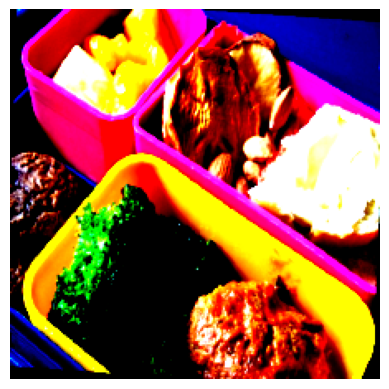

In [91]:
import matplotlib.pyplot as plt
import random

sample_img_arr = img_sample.numpy().transpose(1, 2, 0)
plt.imshow(sample_img_arr)
plt.axis('off')
cap_sample[2]

In [ ]:
import matplotlib.pyplot as plt

img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis('off')

In [ ]:
dataset_notransform = COCOImage(img_path,transform = None)
img_notransform = dataset[0]
img_notransform = img_notransform.numpy().transpose(1, 2, 0)
plt.imshow(img_notransform)
plt.axis('off')

In [ ]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import BertTokenizer

class COCOImageCaptionDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        
        # Load annotations
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Define default transform if not provided
        self.transform = transform or transforms.Compose([
            transforms.RandomGrayscale(p=0.3),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Initialize tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Get list of image files
        self.image_files = [
            os.path.join(img_dir, file)
            for file in os.listdir(img_dir)
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
    
    def __len__(self):
        return len(self.annotations['annotations'])
    
    def __getitem__(self, idx):
        # Get annotation
        ann = self.annotations['annotations'][idx]
        
        # Load image
        img_path = f"{self.img_dir}/{ann['image_id']:012d}.jpg"
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Anchor caption
        caption = ann['caption']
        encoding = self.tokenizer(caption, padding='max_length', 
                                  truncation=True, max_length=64,
                                  return_tensors='pt')
        
        # Negative caption (random from dataset)
        neg_idx = random.choice([i for i in range(len(self)) if i != idx])
        neg_caption = self.annotations['annotations'][neg_idx]['caption']
        neg_encoding = self.tokenizer(neg_caption, padding='max_length',
                                      truncation=True, max_length=64,
                                      return_tensors='pt')
        
        return {
            'image': image,
            'caption_ids': encoding['input_ids'].squeeze(0),
            'caption_mask': encoding['attention_mask'].squeeze(0),
            'neg_caption_ids': neg_encoding['input_ids'].squeeze(0),
            'neg_caption_mask': neg_encoding['attention_mask'].squeeze(0)
        }